# Histogram of Hits

Histogram about the distribution of correct answerers' ranking

X: position in the rank
Y: frequency of correct answerers in a certain rank

In [ ]:
import pandas

### Constants

In [2]:
scenarios = ["A","B","C","D"]

base_path = "/Users/pestefo/u/ra_recommendator_conrec/results"

folders = ["20190714_1211_6p", "20190714_1213_5p", "20190714_1231_7p", "20190714_1231_8p", "20190714_1232_9p", "20190714_1233_10p", "20190714_1234_3p", "20190714_1235_4p", "20190714_1236_2p", ]

db_file = "/Users/pestefo/u/ra_recommendator_conrec/data/v1.2.db"
# db_file = "/Users/pestefo/u/ra_recommendator_conrec/data/v1.db"

### Helper functions

In [3]:
import os
from tqdm import tqdm

def get_all_files_from_path(path):
    return [pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')]

In [4]:
import ast

def get_data_from_file(path):
    with open(path, "r") as fp:
        return ast.literal_eval(fp.read())

def get_position_in_ranking(user_id, file_path):
    for index, pair in enumerate(get_data_from_file(file_path)):
        if pair[0] == user_id:
            return index

In [5]:
import sqlite3 

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

def get_correct_answerer_for_question(conn, question_id):
    query = f"""
    SELECT author
        FROM ros_answer
        WHERE id in (SELECT ros_answer_id
        FROM ros_question_answer
        WHERE ros_question_id = {question_id}) and is_accepted=1
    """
#     print(query)
    cur = conn.cursor()
    cur.execute(query)

    rows = cur.fetchall()
    if len(rows) == 0:
        return -1
    return rows[0][0]


### Script to get the data

In [6]:
scenarios = ["A","B","C","D"]

base_path = "/Users/pestefo/u/ra_recommendator_conrec/results"

frequencies = {"A": [],"A-q": [], "B": [],"B-q": [], "C": [], "C-q": [], "D": [], "D-q": [] }

conn=create_connection(db_file)

list_of_unknown_answerers = 0

for scenario in tqdm(scenarios, desc="Scenarios"):
    for folder in folders:
        path = base_path + '/' + folder + '/' + scenario
        
        files = get_all_files_from_path(path)

        for file in files:
            if not file.endswith('.json'):
                continue
            question_id=file[:-5]
            user_id = get_correct_answerer_for_question(conn=conn, question_id=question_id)
            if user_id == -1:
                list_of_unknown_answerers += 1
                continue
            frequencies[scenario].append(get_position_in_ranking(user_id=user_id,file_path=path+"/"+file))
            frequencies[scenario+"-q"].append(question_id)


Scenarios: 100%|█████████████████████████████████| 4/4 [17:28<00:00, 262.14s/it]


In [8]:
import pandas

max_nb_of_questions = max([len(data) for key, data in frequencies.items()])

# Normalize number of elements to max_nb_of_questions
for key, value in frequencies.items():
    if len(value) < max_nb_of_questions:
        value.extend([None]*(max_nb_of_questions-len(value)))

# Create dataframe    
df = pandas.DataFrame.from_dict(frequencies)


In [9]:
# Dataframe cleaning and preprocessing
# Drop the file with questions in None
df = df.drop(df.index[df['B-q'].isnull()])

# Assigning a high value to questions 
# where the correct anwerer was not found
MAX_RANKING = 100
df = df.fillna(MAX_RANKING)

In [247]:
# Save the dataframe for further import
# df.to_csv("hits_data.csv")
# df = pandas.read_c
# df

In [10]:
df

A     A-q     B     B-q     C     C-q     D     D-q
0        1.0   52790  12.0   52790  11.0   52790  31.0   52790
1        4.0   30339   1.0   30339   2.0   30339   2.0   30339
2        1.0  195962  14.0  195962   1.0  195962   9.0  195962
3        3.0   11167   4.0   11167   5.0   11167   6.0   11167
4      100.0  173089  41.0  173089  27.0  173089  50.0  173089
...      ...     ...   ...     ...   ...     ...   ...     ...
22289  100.0  207520   0.0  256485   0.0  256485   0.0  256485
22290    0.0  256485  13.0  279796   2.0  279796   2.0  279796
22291    2.0  279796  34.0   44811  11.0   44811  25.0   44811
22292   43.0   44811  23.0    9587   1.0    9587  14.0    9587
22293    1.0    9587   8.0   40501   3.0   40501   2.0   40501

[22294 rows x 8 columns]

### Histogram of results

In [21]:
import plotly.express as px

fig = px.histogram(df, x="A",
                   title='Histogram of Answerers Position - Scenario A (Q U)',
                   labels={'A':'ranking'}, # can specify one label per df column
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'] # color of histogram bars
                   )
fig.update_yaxes(range=[0,6500])
fig.show()

In [20]:
import plotly.express as px

fig = px.histogram(df, x="B",
                   title='Histogram of Answerers Position - Scenario B (Q+ U)',
                   labels={'B':'ranking'}, # can specify one label per df column
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'] # color of histogram bars
                   )
fig.update_yaxes(range=[0,6500])
fig.show()

In [18]:
import plotly.express as px

fig = px.histogram(df, x="C",
                   title='Histogram of Answerers Position - Scenario C (Q U+)',
                   labels={'C':'ranking'}, # can specify one label per df column
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'] # color of histogram bars
                   )
fig.update_yaxes(range=[0,6500])
fig.show()

In [19]:
import plotly.express as px

fig = px.histogram(df, x="D",
                   title='Histogram of Answerers Position - Scenario D (Q+ U+)',
                   labels={'D':'ranking'}, # can specify one label per df column
                   opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'] # color of histogram bars
                   
                   )
fig.update_yaxes(range=[0,6500])
fig.show()

## Histogram with good (<=5) and poor (>5) performance

In [26]:
df2 = df.copy()

df2.A.values[df2.A.values <= 10] = 0
df2.B.values[df2.B.values <= 10] = 0
df2.C.values[df2.C.values <= 10] = 0
df2.D.values[df2.D.values <= 10] = 0

df2.A.values[df2.A.values > 10] = 1
df2.B.values[df2.B.values > 10] = 1
df2.C.values[df2.C.values > 10] = 1
df2.D.values[df2.D.values > 10] = 1


In [31]:
import plotly.express as px
fig = px.histogram(df2, x="A",
                   title='Histogram of Answerers Position (2) - Scenario A (Q U)',
                   labels={'A':'ranking'}, # can specify one label per df column
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

In [28]:
import plotly.express as px
fig = px.histogram(df2, x="B",
                   title='Histogram of Answerers Position (2) - Scenario B (Q+ U)',
                   labels={'B':'ranking'}, # can specify one label per df column
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

In [29]:
import plotly.express as px
fig = px.histogram(df2, x="C",
                   title='Histogram of Answerers Position (2) - Scenario C (Q U+)',
                   labels={'C':'ranking'}, # can specify one label per df column
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

In [30]:
import plotly.express as px
fig = px.histogram(df2, x="D",
                   title='Histogram of Answerers Position (2) - Scenario D (Q+ U+)',
                   labels={'D':'ranking'}, # can specify one label per df column
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

## Check nb of Tags in Questions with good/poor performance

### Helper functions

In [259]:
def get_nb_of_tags_of_questions(conn, questions):
    questions_string = ",".join(questions)

    query = f"""
    SELECT ros_question_id, count(ros_tag_id)
    FROM ros_question_tag
    WHERE ros_question_id in ({questions_string})
    GROUP BY ros_question_id
    """

    cur = conn.cursor()
    cur.execute(query)

    rows = cur.fetchall()

    df = pandas.DataFrame.from_records(rows)
    df = df.rename(columns = {0:"question_id",1:"tags"})
    return df

## Scenario A 

In [260]:
questions_scenario_A_with_good_performance = df[["A", "A-q"]][df.A.values < 6]["A-q"].to_list()
df_q_good_performance_A = get_nb_of_tags_of_questions(conn, questions_scenario_A_with_good_performance) 

fig = px.histogram(df_q_good_performance_A, x="tags",
                   title='Histogram of Tags in questions with GOOD performance - Scenario A (Q U)',
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

In [261]:
questions_scenario_A_with_poor_performance = df[["A", "A-q"]][df.A.values > 5]["A-q"].to_list()
df_q_poor_performance_A = get_nb_of_tags_of_questions(conn, questions_scenario_A_with_poor_performance) 

fig = px.histogram(df_q_poor_performance_A, x="tags",
                   title='Histogram of Tags in questions with POOR performance - Scenario A (Q U)',
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

## Scenario B

In [262]:
questions_scenario_B_with_good_performance = df[["B", "B-q"]][df.B.values < 6]["B-q"].to_list()
df_q_good_performance_B = get_nb_of_tags_of_questions(conn, questions_scenario_B_with_good_performance) 

fig = px.histogram(df_q_good_performance_B, x="tags",
                   title='Histogram of Tags in questions with GOOD performance - Scenario B (Q+ U)',
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

In [263]:
questions_scenario_B_with_poor_performance = df[["B", "B-q"]][df.B.values > 5]["B-q"].to_list()
df_q_poor_performance_B = get_nb_of_tags_of_questions(conn, questions_scenario_B_with_poor_performance) 

fig = px.histogram(df_q_poor_performance_B, x="tags",
                   title='Histogram of Tags in questions with POOR performance - Scenario B (Q+ U)',
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

## Scenario C

In [264]:
questions_scenario_C_with_good_performance = df[["C", "C-q"]][df.C.values <= 5]["C-q"].to_list()
df_q_good_performance_C = get_nb_of_tags_of_questions(conn, questions_scenario_C_with_good_performance) 

fig = px.histogram(df_q_good_performance_C, x="tags",
                   title='Histogram of Tags in questions with GOOD performance - Scenario C (Q U+)',
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

In [265]:
questions_scenario_C_with_poor_performance = df[["C", "C-q"]][df.C.values > 5]["C-q"].to_list()
df_q_poor_performance_C = get_nb_of_tags_of_questions(conn, questions_scenario_C_with_poor_performance) 

fig = px.histogram(df_q_poor_performance_C, x="tags",
                   title='Histogram of Tags in questions with POOR performance - Scenario C (Q U+)',
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

## Scenario D

In [266]:
questions_scenario_D_with_good_performance = df[["D", "D-q"]][df.D.values < 6]["D-q"].to_list()
df_q_good_performance_D = get_nb_of_tags_of_questions(conn, questions_scenario_D_with_good_performance) 

fig = px.histogram(df_q_good_performance_D, x="tags",
                   title='Histogram of Tags in questions with GOOD performance - Scenario C (Q U+)',
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

In [267]:
questions_scenario_D_with_poor_performance = df[["D", "D-q"]][df.D.values > 10]["D-q"].to_list()
df_q_poor_performance_D = get_nb_of_tags_of_questions(conn, questions_scenario_D_with_poor_performance) 

fig = px.histogram(df_q_poor_performance_D, x="tags",
                   title='Histogram of Tags in questions with POOR performance - Scenario C (Q U+)',
#                    opacity=0.8,
#                    log_y=True, # represent bars with log scale
                   color_discrete_sequence=['blue'], # color of histogram bars
                   text_auto=True
                   )
fig.show()

## Tags in questions with Good/Bad performance

In [307]:
def get_tags_count_for_questions(conn,question_ids):
    questions_string = ",".join(question_ids)

    query = f"""
SELECT name, count(id)
FROM ros_question_tag INNER JOIN ros_tag ON ros_tag_id == id
WHERE ros_question_id in ({questions_string})
GROUP BY id

    """

    cur = conn.cursor()
    cur.execute(query)

    rows = cur.fetchall()

    df = pandas.DataFrame.from_records(rows)
    df = df.rename(columns = {0:"tag",1:"count"})
    return df
    

### Tags in questions with good performance

In [333]:
df_C_questions_with_rank_0 = df[["C", "C-q"]][df["C"] == 0]
df_C_tags_count_good_performance = get_tags_count_for_questions(conn, df_C_questions_with_rank_1["C-q"].tolist())

In [327]:
import matplotlib.pyplot as plt
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    
def generate_string_for_worldcloud(df):
    string = ""
    for idx, row in df.iterrows():
        for i in range(row.loc['count']):
            string = string + row.loc["tag"] + " "
    return string

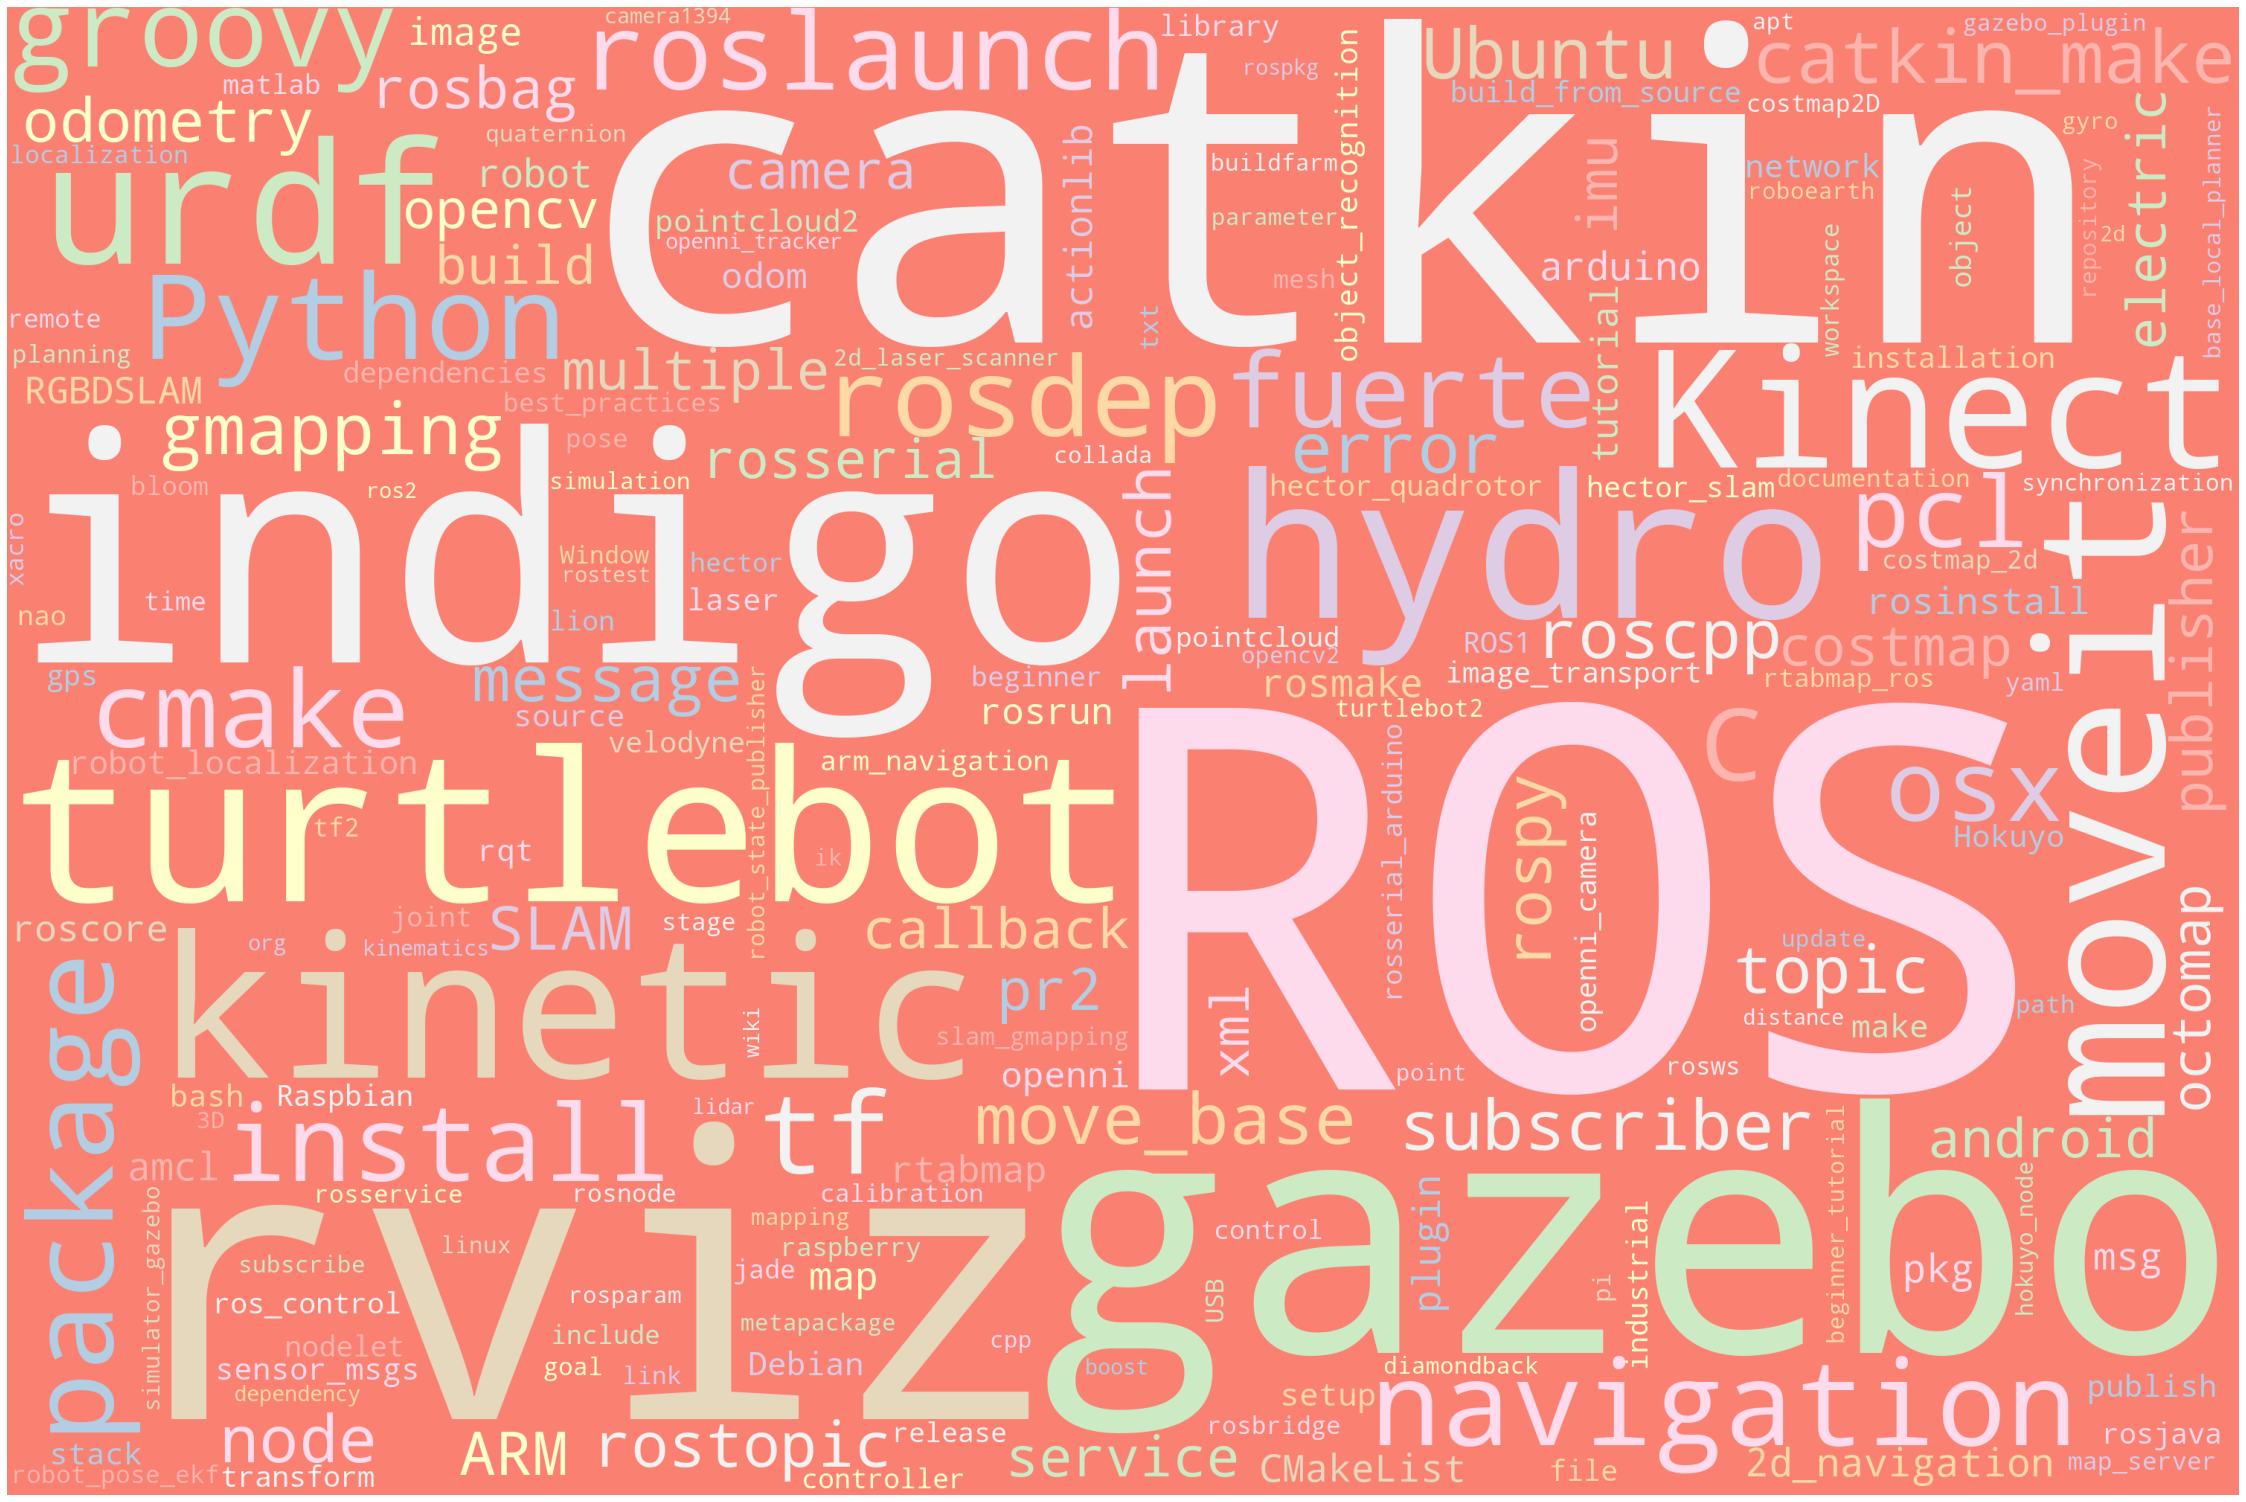

In [328]:
from wordcloud import WordCloud

string = generate_string_for_worldcloud(df_C_tags_count_good_performance)
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False).generate(string)
# Plot
plot_cloud(wordcloud)

### Tags in questions with bad performance

In [334]:
df_C_questions_with_bad_performance = df[["C", "C-q"]][df["C"] > 5]
df_C_tags_count_bad_performance = get_tags_count_for_questions(conn, df_C_questions_with_bad_performance["C-q"].tolist())

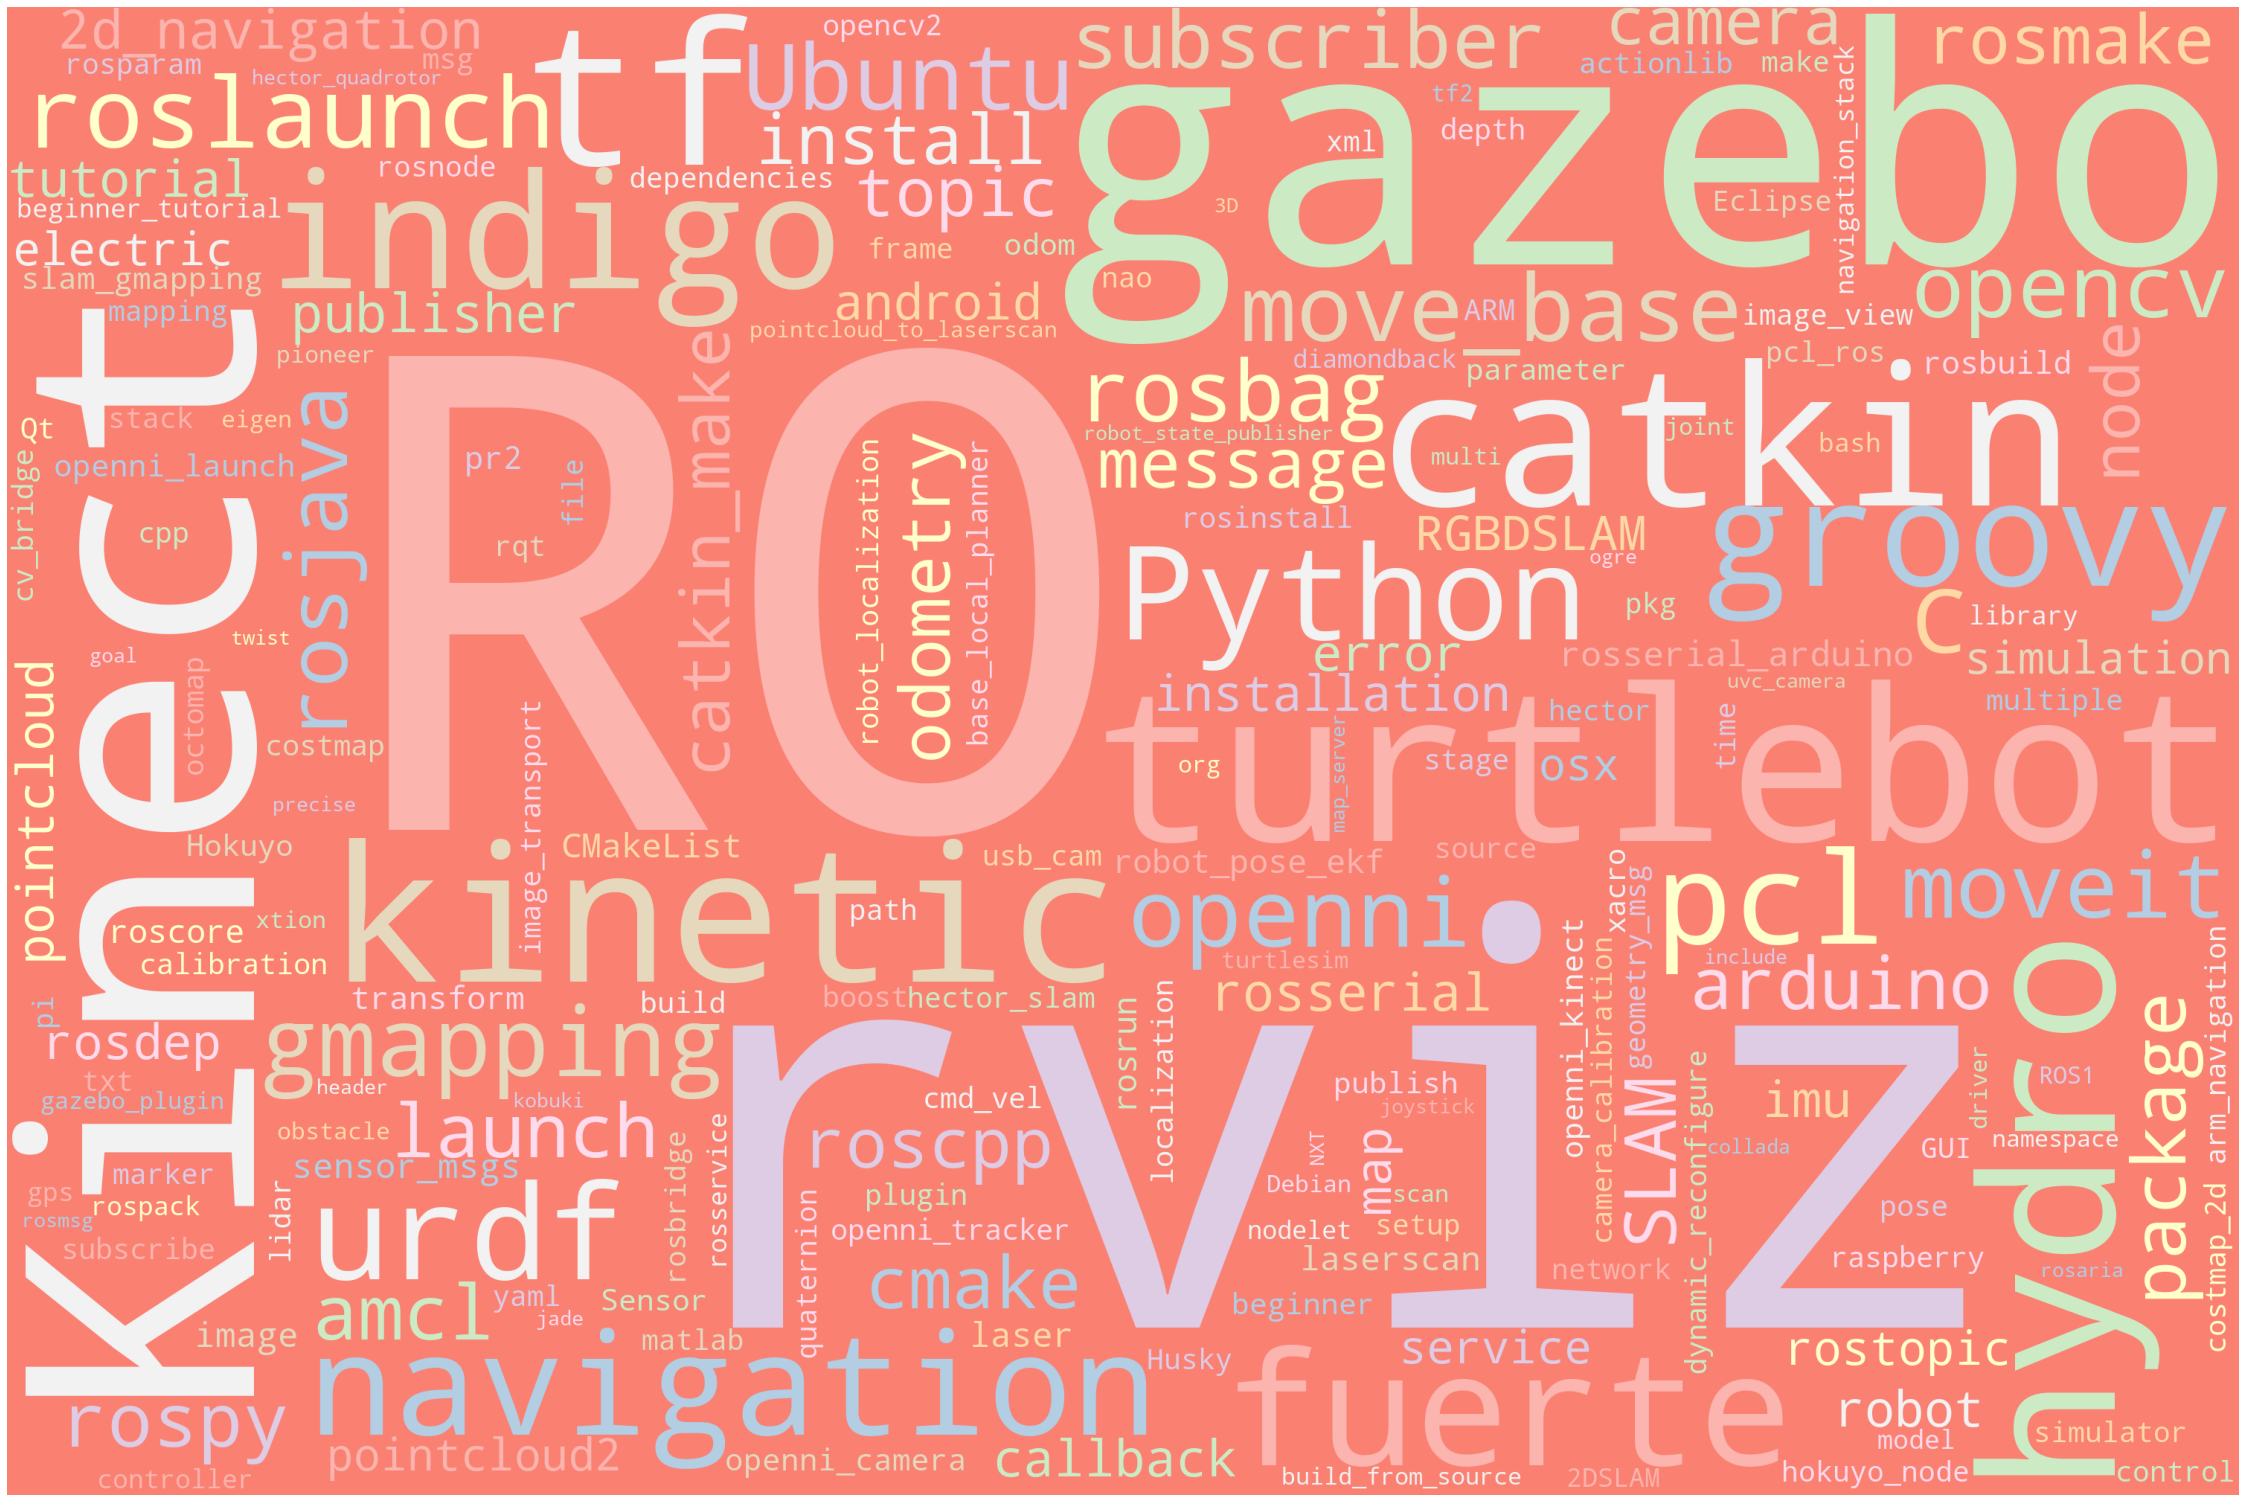

In [335]:
string = generate_string_for_worldcloud(df_C_tags_count_bad_performance)
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False).generate(string)
# Plot
plot_cloud(wordcloud)

### Analisys of specific cases

In [381]:
def question_tags(conn,question_id: str):
    query = f"""
    SELECT name
    FROM ros_question_tag INNER JOIN ros_tag ON ros_tag_id == id
    WHERE ros_question_id = "{question_id}"
    """

    cur = conn.cursor()
    cur.execute(query)

    rows = cur.fetchall()
    rows = [row[0] for row in rows]
    return rows

def get_tags_of_an_user(conn, user_id):
    query = f"""
    SELECT name
    FROM ros_user_tag INNER JOIN ros_tag ON ros_tag_id == id
    WHERE ros_user_id = "{user_id}"
    """

    cur = conn.cursor()
    cur.execute(query)

    rows = cur.fetchall()
    rows = [row[0] for row in rows]
    return rows

def question_answerer_tags(conn, question_id):
    return get_tags_of_an_user(conn, get_correct_answerer_for_question(conn, question_id))

def question_best_ranked_user_tags(conn, question_id):
    scenario = "C"
    best_ranked_user = None
    for folder in folders:
        path = base_path + '/' + folder + '/' + scenario
        
        files = get_all_files_from_path(path)

        for file in files:
            if not file.endswith('.json'):
                continue
            current_question_id=file[:-5]
            
            if current_question_id == question_id:
                best_ranked_user = get_data_from_file(path+"/"+file)[0][0]
    if best_ranked_user is None:
        raise Exception("Question not found")
        
    return get_tags_of_an_user(conn,best_ranked_user)


In [361]:
question_with_bad_performance = df[["C", "C-q"]][df["C"] >= 100].iloc[0,1]
question_with_bad_performance

# Question tags
question_tags(conn, question_with_bad_performance)

['diamondback', 'install', 'dependency']

In [379]:
# Answerer
question_answerer_tags(conn, question_with_bad_performance)

['bumblebee2',
 'rviz',
 'libdc1394',
 'bumblebee',
 'camera',
 'diamondback',
 'opencv',
 'rosmake',
 'camera_drivers',
 'roslaunch',
 'roscpp',
 'move_base',
 'camera1394',
 'gazebo',
 'dependency',
 'opencv2.2',
 'image_transport',
 'boost',
 'openni_kinect',
 'install',
 'hokuyo_node',
 'camera_info',
 'ar_pose',
 'erratic',
 'rosrun',
 'points_and_lines',
 'electric',
 'erratic_gazebo',
 'bumblebee1394',
 'Qt',
 'Sensor',
 'Debian',
 'Kinect']

In [382]:
# Top scored
question_best_ranked_user_tags(conn, question_with_bad_performance)

['tf',
 'turtlebot',
 'ROS',
 'rosdep',
 'gazebo',
 'Kinect',
 'rviz',
 'hydro',
 'indigo',
 'kinetic',
 'tf2',
 'rosinstall',
 'install',
 'Ubuntu',
 'fuerte',
 'groovy',
 'Python',
 'catkin',
 'rosbag',
 'openni',
 'installation',
 'roslaunch',
 'rosmake',
 'pcl',
 'answers.ros.org',
 'rospy',
 'navigation',
 'package',
 'roscpp',
 'error',
 'gmapping',
 'nodelet',
 'roscore',
 'subscriber',
 'Debian',
 'opencv',
 'buildfarm',
 'osx',
 'ros2',
 'urdf',
 'C++',
 'ARM',
 'cmake',
 'move_base',
 'pointcloud',
 'boost',
 'openni_kinect',
 'dependencies',
 'rosjava',
 'diamondback']

In [399]:
question_with_good_performance = df[["C", "C-q"]][df["C"] == 0].iloc[2,1]
question_with_good_performance

# Question tags
question_tags(conn, question_with_good_performance)

['catkin_make', 'ork']

In [400]:
# Answerer
question_answerer_tags(conn, question_with_good_performance)

['kinetic',
 'ROS',
 'indigo',
 'moveit',
 'catkin',
 'rviz',
 'gazebo',
 'urdf',
 'catkin_make',
 'ros-industrial',
 'roslaunch',
 'Python',
 'cmake',
 'C++',
 'ROS1',
 'lunar',
 'rospy',
 'ur5',
 'error',
 'tf',
 'Ubuntu',
 'roscpp',
 'rosbag',
 'camera',
 'hydro',
 'subscriber',
 'rosrun',
 'install',
 'rosserial',
 'abb',
 'industrial',
 'package',
 'publisher',
 'Debian',
 'ikfast',
 'ros2',
 'ros_control',
 'catkin-make',
 'opencv',
 'turtlebot',
 'Kinect',
 'rostopic',
 'rosdep',
 'callback',
 'roscore',
 'dependencies',
 'robot',
 'service',
 'CMakeLists.txt',
 'node']

In [401]:
# Top scored
question_best_ranked_user_tags(conn, question_with_good_performance)

['kinetic',
 'ROS',
 'indigo',
 'moveit',
 'catkin',
 'rviz',
 'gazebo',
 'urdf',
 'catkin_make',
 'ros-industrial',
 'roslaunch',
 'Python',
 'cmake',
 'C++',
 'ROS1',
 'lunar',
 'rospy',
 'ur5',
 'error',
 'tf',
 'Ubuntu',
 'roscpp',
 'rosbag',
 'camera',
 'hydro',
 'subscriber',
 'rosrun',
 'install',
 'rosserial',
 'abb',
 'industrial',
 'package',
 'publisher',
 'Debian',
 'ikfast',
 'ros2',
 'ros_control',
 'catkin-make',
 'opencv',
 'turtlebot',
 'Kinect',
 'rostopic',
 'rosdep',
 'callback',
 'roscore',
 'dependencies',
 'robot',
 'service',
 'CMakeLists.txt',
 'node']

In [1]:
max_nb_of_questions

NameError: name 'max_nb_of_questions' is not defined